In [1]:
import requests
import json
import time
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from scipy import stats
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
from datetime import datetime

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
weather = pd.read_csv('weather.csv')
spray = pd.read_csv('spray.csv')
test = pd.read_csv('test.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
Id                        116293 non-null int64
Date                      116293 non-null object
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null int64
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [5]:
def clean_train_data(df):
    
    # map df dataset with weather dataset
    mask3 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) <= \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    mask4 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) > \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    df.loc[mask3,'weather_station'] = 1
    df.loc[mask4,'weather_station'] = 2
    df_weather = df.join(weather.set_index(['Date','Station']), on=(['Date','weather_station']), how='left')

    # map df_weather dataset with spray dataset
    date_format = "%Y-%m-%d"
    date_formated_df = []
    date_formated_spray = []
    for i in df_weather['Date']:
        date_formated_df.append(datetime.strptime(i, date_format))
    for i in spray['Date']:
        date_formated_spray.append(datetime.strptime(i, date_format))
    date_formated_spray = set(date_formated_spray)
    date_formated_spray = list(date_formated_spray)
    days_after_spray = []
    for i in date_formated_df:
        delta = []
        for n in date_formated_spray:
            if (i - n).days > 0:
                delta.append((i - n).days)
        if len(delta) != 0:
            days = np.min(delta)
        else:
            days = 0
        days_after_spray.append(days)
    df_weather['days_after_spray'] = days_after_spray
    
    # clean up the total dataset 
    df_total = df_weather
    
    ## drop useless columns
    ## different for train and test dataset because test data doesn't include 'NumMosquitos' column
    ## and test data has "Id" column that need to be dropped
    
    df_total = df_total.drop(['Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
              'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
              'Water1','SnowFall','Sunrise','Sunset','NumMosquitos'],axis=1)
              # NumMosquitos and CodeSum may still helpful (test data doesn't include 'NumMosquitos' column)
    
    
    ## deal with the missing value of the useful columns
    mask5 = (df_total.PrecipTotal == '  T')| (df_total.PrecipTotal =='M')
    mask6 = df_total.WetBulb == 'M'
    mask7 = df_total.StnPressure == 'M'
    df_total.loc[mask5,'PrecipTotal'] = 0.00
    df_total.loc[mask6,'WetBulb'] = round((df_total[df_total.WetBulb!='M']['WetBulb']).astype('int').mean())
    df_total.loc[mask7,'StnPressure'] = round((df_total[df_total.StnPressure!='M']['StnPressure']).astype('float').mean(),2)
    
    ## change the datatype to correct one
    df_total[['Tavg','WetBulb','Heat','Cool']] = df_total[['Tavg','WetBulb','Heat','Cool']].astype(int)
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']] = \
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']].astype(float)
    
    ## dummy the object variable
    df_total = pd.get_dummies(df_total,drop_first=True,columns=['Species'])
    
    # return cleaned dataframe

    return df_total

In [6]:
def clean_test_data(df):
    
    # map df dataset with weather dataset
    mask3 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) <= \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    mask4 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) > \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    df.loc[mask3,'weather_station'] = 1
    df.loc[mask4,'weather_station'] = 2
    df_weather = df.join(weather.set_index(['Date','Station']), on=(['Date','weather_station']), how='left')

    # map df_weather dataset with spray dataset
    date_format = "%Y-%m-%d"
    date_formated_df = []
    date_formated_spray = []
    for i in df_weather['Date']:
        date_formated_df.append(datetime.strptime(i, date_format))
    for i in spray['Date']:
        date_formated_spray.append(datetime.strptime(i, date_format))
    date_formated_spray = set(date_formated_spray)
    date_formated_spray = list(date_formated_spray)
    days_after_spray = []
    for i in date_formated_df:
        delta = []
        for n in date_formated_spray:
            if (i - n).days > 0:
                delta.append((i - n).days)
        if len(delta) != 0:
            days = np.min(delta)
        else:
            days = 0
        days_after_spray.append(days)
    df_weather['days_after_spray'] = days_after_spray
    
    # clean up the total dataset 
    df_total = df_weather
    
    ## drop useless columns
    ## different for train and test dataset because test data doesn't include 'NumMosquitos' column
    ## and test data has "Id" column that need to be dropped
    
    ### for train dataset
#     df_total = df_total.drop(['Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
#               'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
#               'Water1','SnowFall','Sunrise','Sunset','NumMosquitos'],axis=1)
                 
                 # NumMosquitos and CodeSum may still helpful (test data doesn't include 'NumMosquitos' column)
    
    ### for test dataset
    df_total = df_total.drop(['Id','Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
               'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
               'Water1','SnowFall','Sunrise','Sunset'],axis=1)
    
    
    ## deal with the missing value of the useful columns
    mask5 = (df_total.PrecipTotal == '  T')| (df_total.PrecipTotal =='M')
    mask6 = df_total.WetBulb == 'M'
    mask7 = df_total.StnPressure == 'M'
    df_total.loc[mask5,'PrecipTotal'] = 0.00
    df_total.loc[mask6,'WetBulb'] = round((df_total[df_total.WetBulb!='M']['WetBulb']).astype('int').mean())
    df_total.loc[mask7,'StnPressure'] = round((df_total[df_total.StnPressure!='M']['StnPressure']).astype('float').mean(),2)
    
    ## change the datatype to correct one
    df_total[['Tavg','WetBulb','Heat','Cool']] = df_total[['Tavg','WetBulb','Heat','Cool']].astype(int)
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']] = \
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']].astype(float)
    
    ## dummy the object variable
    df_total = pd.get_dummies(df_total,drop_first=True,columns=['Species'])
    
    ## drop one of the dummy variable 'Species_UNSPECIFIED CULEX' that train dataset doesn't have
    df_total = df_total.drop(['Species_UNSPECIFIED CULEX'],axis=1)
    
    # create polynomial features
    
    ## for train dataset
#     y = df_total['WnvPresent']
#     X = df_total.drop('WnvPresent',axis=1)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.15)
#     poly = PolynomialFeatures(include_bias=False,degree=2)
#     X_train_poly = poly.fit_transform(X_train)
#     X_test_poly = poly.transform(X_test)
#     X_train=pd.DataFrame(X_train_poly,columns=poly.get_feature_names(X_train.columns))
#     X_test=pd.DataFrame(X_test_poly,columns=poly.get_feature_names(X_test.columns))
    
    ## for test dataset
#     poly = PolynomialFeatures(include_bias=False,degree=2)
#     df_total_poly = poly.fit_transform(df_total)
#     df_total=pd.DataFrame(df_total_poly,columns=poly.get_feature_names(df_total.columns))
    
    # return cleaned dataframe
    
    ## for train dataset, return X_train and X_test data
#     return X_train, X_test
    
    ## for test dataset, return df_total
    return df_total

In [7]:
test_clean = clean_test_data(test)
test_clean.shape

(116293, 22)

In [8]:
train_clean = clean_train_data(df)
train_clean.shape

(10506, 23)

In [9]:
train_clean['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In [10]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 23 columns):
Latitude                          10506 non-null float64
Longitude                         10506 non-null float64
WnvPresent                        10506 non-null int64
Tmax                              10506 non-null int64
Tmin                              10506 non-null int64
Tavg                              10506 non-null int64
DewPoint                          10506 non-null int64
WetBulb                           10506 non-null int64
Heat                              10506 non-null int64
Cool                              10506 non-null int64
PrecipTotal                       10506 non-null float64
StnPressure                       10506 non-null float64
SeaLevel                          10506 non-null float64
ResultSpeed                       10506 non-null float64
ResultDir                         10506 non-null int64
AvgSpeed                          10506 non-null float

### upsample the dataset

In [11]:
# upsample the minority df_total['WnvPresent'] == 1
from sklearn.utils import resample

## Separate majority and minority classes
df_majority = train_clean[train_clean.WnvPresent==0]
df_minority = train_clean[train_clean.WnvPresent==1]
 
## Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=9955,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.WnvPresent.value_counts()

1    9955
0    9955
Name: WnvPresent, dtype: int64

In [74]:
sns.pairplot(df_upsampled)

In [12]:
df_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19910 entries, 0 to 2969
Data columns (total 23 columns):
Latitude                          19910 non-null float64
Longitude                         19910 non-null float64
WnvPresent                        19910 non-null int64
Tmax                              19910 non-null int64
Tmin                              19910 non-null int64
Tavg                              19910 non-null int64
DewPoint                          19910 non-null int64
WetBulb                           19910 non-null int64
Heat                              19910 non-null int64
Cool                              19910 non-null int64
PrecipTotal                       19910 non-null float64
StnPressure                       19910 non-null float64
SeaLevel                          19910 non-null float64
ResultSpeed                       19910 non-null float64
ResultDir                         19910 non-null int64
AvgSpeed                          19910 non-null float6

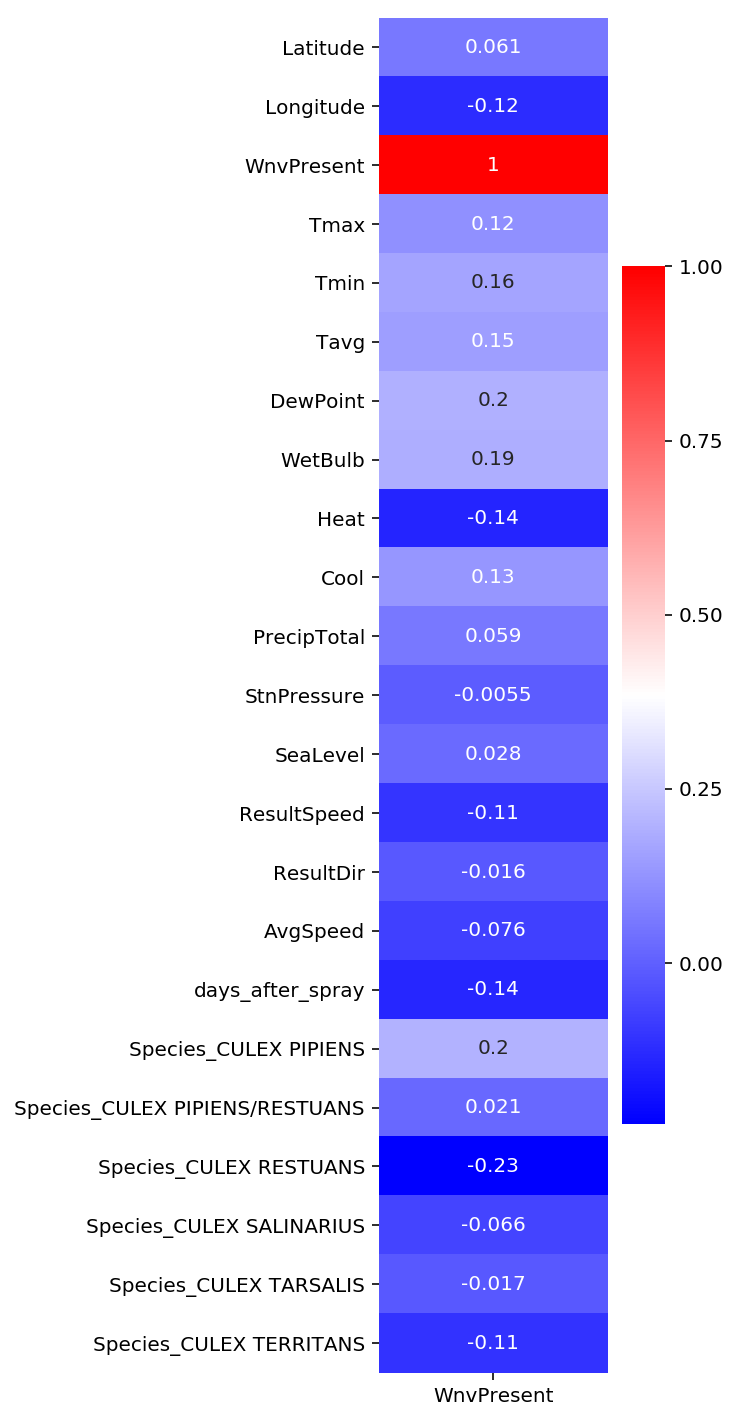

In [13]:
plt.figure(figsize=(5,10))
sns.heatmap(df_upsampled.corr()[['WnvPresent']],annot=True,cmap='bwr')
plt.tight_layout()

### build the model

In [14]:
y = df_upsampled['WnvPresent']
X = df_upsampled.drop('WnvPresent',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)

In [16]:
# random forest is OK
pip1 = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
params1 = {
    'rf__n_estimators':[5,10,20],
    'rf__max_features': ["auto","sqrt","log2"],
    'rf__max_depth': [None,10,20]
}
gs1 = GridSearchCV(pip1,param_grid=params1)
gs1.fit(X_train,y_train)
print('best cv score', gs1.best_score_)
print('best paramas', gs1.best_params_)
print('test score', gs1.score(X_test, y_test))

best cv score 0.9441588370856231
best paramas {'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 10}
test score 0.9517910947438902


In [17]:
# create a confusion matrix
y_hat = gs1.predict(X_test)
confusion_matrix(y_test,y_hat)

array([[1346,  131],
       [  13, 1497]])

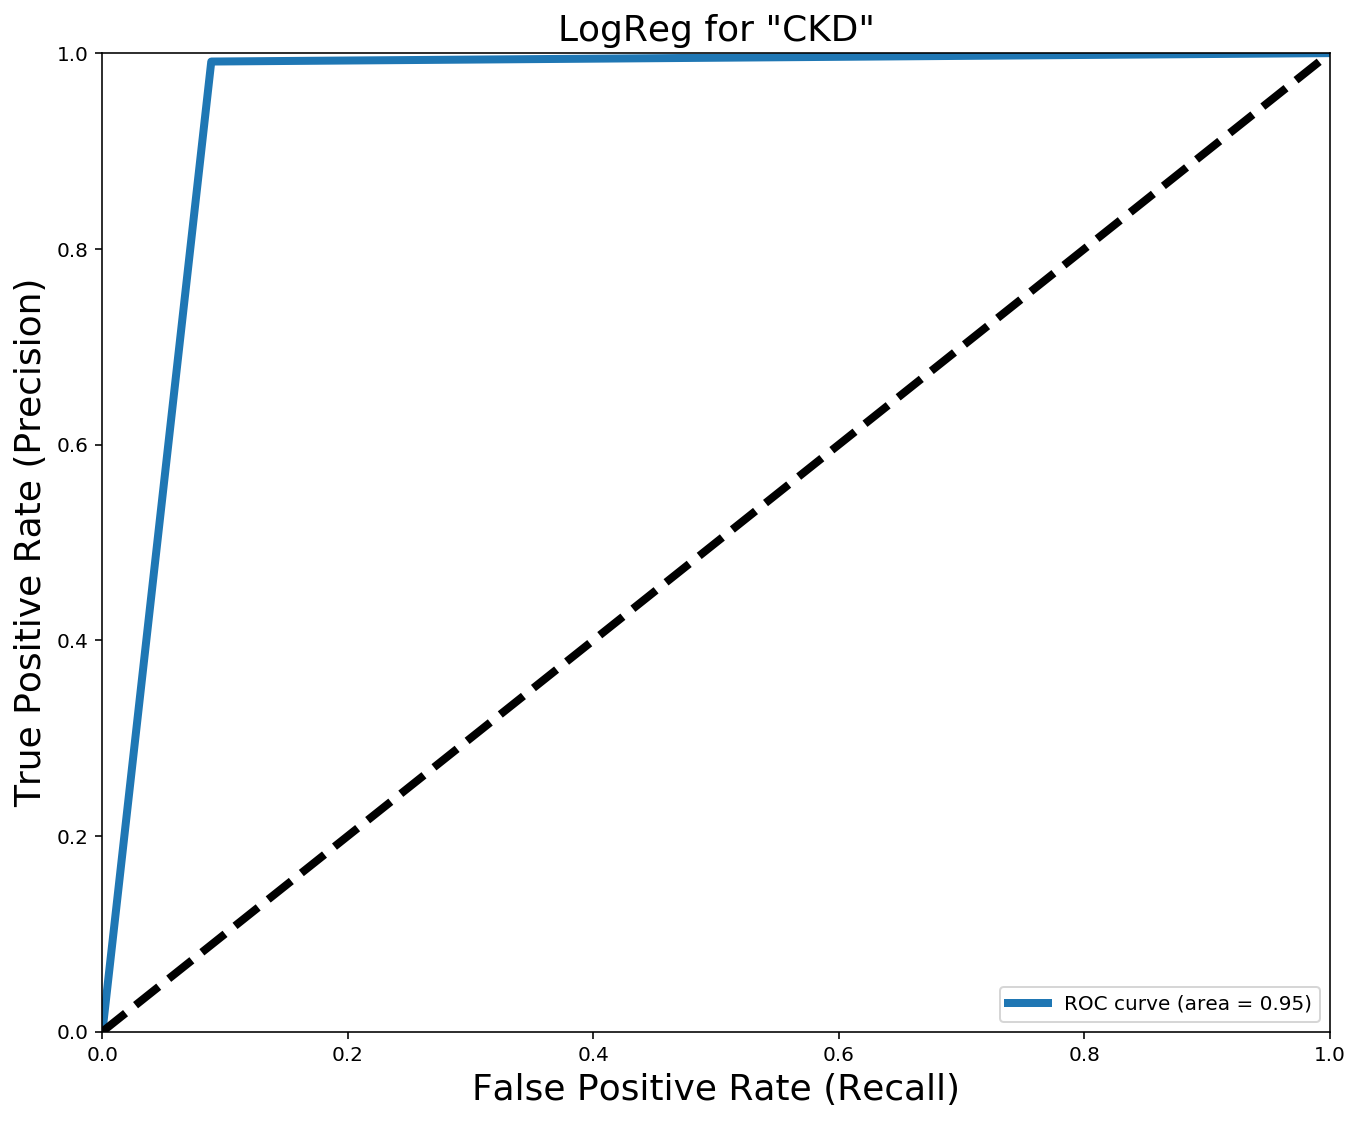

In [28]:
y_pred = gs1.predict(X_test)
FPR, TPR, threshold = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (Recall)', fontsize=18)
plt.ylabel('True Positive Rate (Precision)', fontsize=18)
plt.title('LogReg for "CKD"', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [79]:
# svm
gamma_range = [0.001]
C_range = [1]
kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']

params3 = dict(gamma=gamma_range, kernel=kernel_range, C=C_range)

clf = svm.SVC()
gs3 = GridSearchCV(clf, params3, scoring="accuracy", verbose=0)
gs3.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

NameError: name 'gs' is not defined

In [80]:
print('best cv score', gs3.best_score_)
print('best paramas', gs3.best_params_)
print('test score', gs3.score(X_test, y_test))

best cv score 0.661643916563257
best paramas {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
test score 0.6735855373284232


In [ ]:
# svm using unbalanced sample and use class_weight = 'WnvPresent' to penalize mistakes on the minority class 
# by an amount proportional to how under-represented it is.
y = train_clean['WnvPresent']
X = train_clean.drop('WnvPresent',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)

gamma_range = [0.001]
C_range = [1]
kernel_range = ['linear']
class_weight=['balanced']

params4 = dict(gamma=gamma_range, kernel=kernel_range, C=C_range, class_weight=class_weight)

clf = svm.SVC()
gs4 = GridSearchCV(clf, params4, scoring="accuracy", verbose=0)
gs4.fit(X_train,y_train)

print('best cv score', gs4.best_score_)
print('best paramas', gs4.best_params_)
print('test score', gs4.score(X_test, y_test))

In [25]:
# logistic regression is bad?
pip2 = Pipeline([
    ('ss', StandardScaler()), 
    ('lr', LogisticRegression())
])
params2 = {
    'lr__penalty':['l1','l2'],
    'lr__C':[0.1,0.5,0.9]
}
gs2 = GridSearchCV(pip2,param_grid=params2)
gs2.fit(X_train,y_train)
print('best cv score', gs2.best_score_)
print('best paramas', gs2.best_params_)
print('test score', gs2.score(X_test, y_test))

best cv score 0.6639484724930568
best paramas {'lr__C': 0.1, 'lr__penalty': 'l2'}
test score 0.6672246401071309


In [26]:
# create a confusion matrix
y_hat = gs2.predict(X_test)
confusion_matrix(y_test,y_hat)

array([[ 883,  594],
       [ 400, 1110]])

In [99]:
# FFNN using Tensorflow
y = df_upsampled['WnvPresent']
X = df_upsampled.drop('WnvPresent',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [100]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


In [101]:
X_train.shape

(16923, 22)

In [127]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None,X_train.shape[1]), name='X')
y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name='y')

h1 = tf.layers.dense(X, 20, activation=tf.nn.relu, name='hidden1') # 20 features put into the layer
h2 = tf.layers.dense(h1, 20, activation=tf.nn.relu, name='hidden2')
h3 = tf.layers.dense(h2, 20, activation=tf.nn.relu, name='hidden3')
h4 = tf.layers.dense(h3, 20, activation=tf.nn.relu, name='hidden4')

y_hat = tf.layers.dense(h4, 1, activation=tf.nn.sigmoid, name='y_hat') # this is a binary classification problem

loss = tf.losses.log_loss(y, y_hat)
optimizer = tf.train.AdamOptimizer(.01) # adam do gradient descent: learning rate is little bit larger
training_run = optimizer.minimize(loss)

In [128]:
saver = tf.train.Saver()

In [129]:
init = tf.global_variables_initializer()
train_errs=[]
test_errs=[]
with tf.Session() as sess:
    init.run()
    for epoch in range(1000):
        sess.run(training_run, feed_dict={X: X_train, y: y_train})
        
        if epoch % 100 == 0:
            train_loss = sess.run(loss, feed_dict={X: X_train, y: y_train})
            train_errs.append(train_loss)
            test_loss = sess.run(loss, feed_dict={X: X_test, y: y_test})
            test_errs.append(test_loss)
            print('epoch', epoch, 'Train loss', train_loss, 'Test loss', test_loss)
    saver.save(sess, './Classfication.ckpt')

epoch 0 Train loss 0.66998994 Test loss 0.6698121
epoch 100 Train loss 0.34892967 Test loss 0.36800876
epoch 200 Train loss 0.2935597 Test loss 0.32305723
epoch 300 Train loss 0.2613399 Test loss 0.29614925
epoch 400 Train loss 0.2560089 Test loss 0.2934629
epoch 500 Train loss 0.2493229 Test loss 0.2867506
epoch 600 Train loss 0.24706027 Test loss 0.28402746
epoch 700 Train loss 0.24997738 Test loss 0.3047291
epoch 800 Train loss 0.21582459 Test loss 0.25897345
epoch 900 Train loss 0.19888479 Test loss 0.25000742


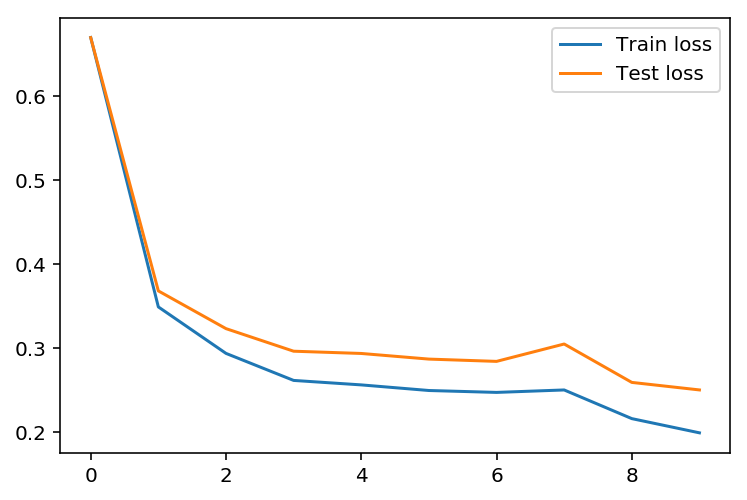

In [131]:
# plot the learning curves
plt.plot(train_errs, label = 'Train loss')
plt.plot(test_errs, label = 'Test loss')
plt.legend()

In [132]:
with tf.Session() as sess:
    saver.restore(sess, './Classfication.ckpt')
    pred = sess.run(y_hat, feed_dict={X:X_test}) # run the prediction layer

In [133]:
classes = (pred > .947).astype(int)
metrics.accuracy_score(y_test, classes)

0.6113157013726147

In [431]:
metrics.confusion_matrix(y_test, classes)

array([[1493,    0],
       [  83,    0]])

In [ ]:
FPR, TPR, threshold = roc_curve(y_test, pred)
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (Recall)', fontsize=18)
plt.ylabel('True Positive Rate (Precision)', fontsize=18)
plt.title('LogReg for "CKD"', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Clean and Predict test data set

In [29]:
test_clean.shape

(116293, 22)

In [30]:
test_pred = gs1.predict(test_clean)

In [31]:
test_pred.shape

(116293,)

In [32]:
test_pred = pd.DataFrame(test_pred)

In [33]:
test_pred['Id'] = [i for i in range(1,116294)]
test_pred['WnvPresent'] = test_pred[0]

In [34]:
test_pred.drop([0],axis=1,inplace=True)

In [35]:
test_pred.tail()

Id  WnvPresent
116288  116289           0
116289  116290           0
116290  116291           0
116291  116292           0
116292  116293           0

In [36]:
test_pred['WnvPresent'].value_counts()

0    115937
1       356
Name: WnvPresent, dtype: int64

In [37]:
test_pred.to_csv('test_pred_2.csv',index=False)